## Deconvolution Simulation Experiments 4
#### Christa Caggiano 
#### September 20th 2018 


Simulations for cfDNA tissue of origin deconvolution. Given an observed matrix of methylation counts for each CpG from whole genome bisulfite sequencing, and a reference matrix of the cannonical proportion methylation for each CpG in each tissue, estimates how much of the cfDNA comes from each tissue in the reference. 

This simulations test the best way to pick sites that are maximally informative for the deconvolution 

In [1]:
#### python packages ####
import pandas as pd
import numpy as np 
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binom
%matplotlib inline
import plotly.plotly as py
import plotly.graph_objs as go

######### loading my python modules for deconvolution ########### 
#### https://github.com/christacaggiano/cfDNA-deconvolution #####

# this code needed to load my modules in a jupyter notebook 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from simulation.simulation_utils import *  # various utils for making simulated data 
from simulation.simulate import generate_simulated_optimization  # takes parameters and makes simulated matrices for optimization 
from optimization.quadratic_programming_optimization import perform_optimization as qp  # performs quadratic programming optimization
from optimization.naive_optimization import perform_optimization as naive  # 'naive' optimization that divides by sum 

#### Functions

In [2]:
# start off by defining the true observed as 100% atrium 

def generate_count_matrices(observed, sites, individuals, read_depth): 

    depth = generate_depth(sites, individuals, read_depth)
    methylated = generate_counts(depth, observed, sites, individuals)  # generate counts using poisson distribution 
    unmethylated = depth - methylated
    
    return methylated, unmethylated

In [3]:
# instead of simulating observed proprotions, we are going to premake the matrix, since it is no longer just
# a function of only the reference 

def generate_optimization(reference, methylated, unmethylated, method):
    """
    using predefined reference and observed proportions, runs an optimization algorithm of choice 
    :param reference (np.array) array of methylation observations 
    :param methylated (np.array)array of methylated counts 
    :param unmethylated (np.array) array of unmethylated counts 
    :param method (string) optimization method
    
    :return estimated proportions  
    
    """
    
    # create initial proportions estimates 
    proportions_est = np.zeros((1, reference.shape[0])) + 0.5  
    proportions_est = proportions_est / (np.sum(proportions_est))

    return method(proportions_est, reference, methylated, unmethylated)

### Load ENCODE data

In [5]:
encode = pd.read_table("../data/small_reference.txt", delim_whitespace=True, header=None )  # load in the roadmap dmrs

In [6]:
encode_no_nan = encode.replace(to_replace=".", value=np.nan).iloc[:, 3:] 
encode_no_nan = encode_no_nan.astype(float)

In [7]:
encode_no_nan_mean = encode_no_nan.fillna(encode_no_nan.mean())

In [8]:
encode_no_nan_mean["var"] = encode_no_nan_mean.var(axis=1, skipna=True) 
encode_10000 = encode_no_nan_mean.sort_values(by="var", ascending=False).iloc[:10000,:-1]

In [9]:
encode_reference = encode_10000.astype(float)
corr = encode_reference.corr()

In [10]:
tissues = pd.read_table("../data/tissues-new-ref-3.txt", header=None)

### Tissue Correlation

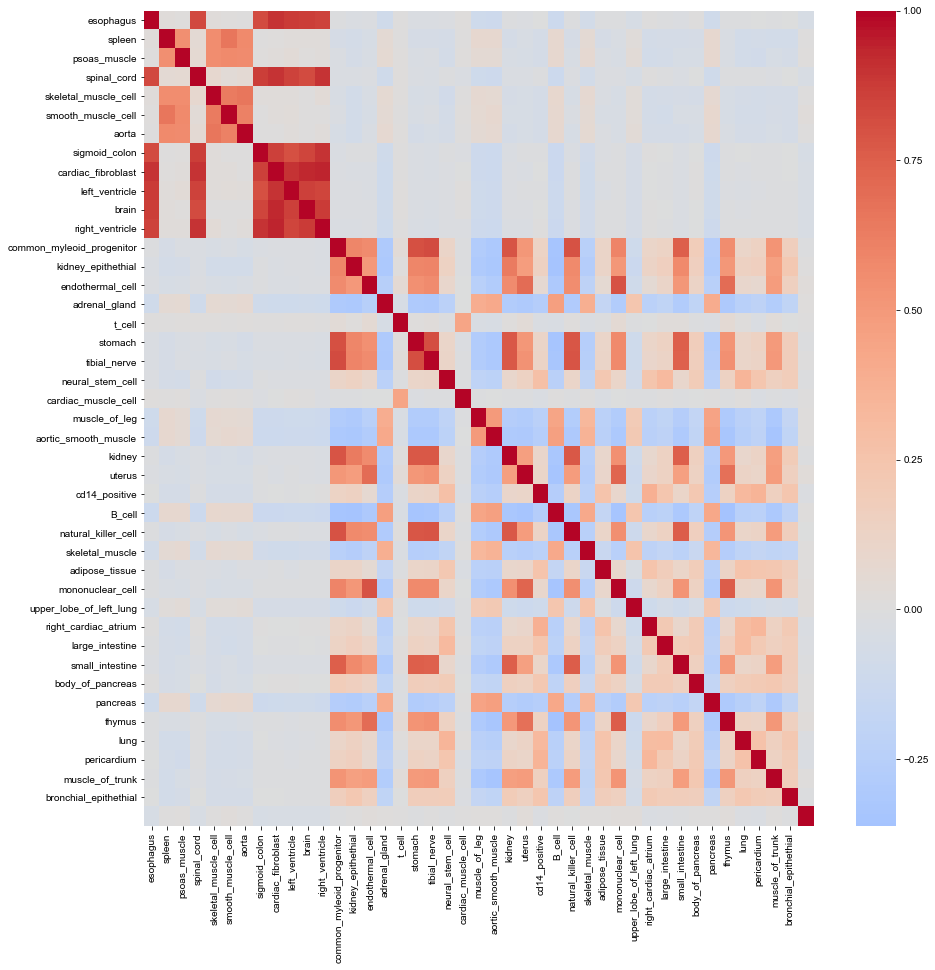

In [11]:
plt.rcParams['figure.figsize'] = [15, 15]

labels = tissues[0].tolist()
sns.heatmap(corr, cmap="coolwarm", center=0.0, xticklabels=labels, yticklabels=labels)
sns.set(font_scale=1.5)
plt.savefig("encode.png")

### Artifical Mixtures

In [12]:
def run_optimization(individuals, sites, tissues, read_depth, method, reference, fixed_proportion, column):
    """
    this function controls the simulation, by generating the simulated matrices given a set of parameters and 
    running the optimization using method of choice 
    
    :param individuals (int) number of individuals in the matrices (since optimization is only 1 person at a time, this is usually one. Will change later)
    :param sites (int) number of CpGs in reference and observed matrix- must be the same 
    :param tissues (int) number of tissues in the reference/tissue proportion matrices 
    :param read_depth (int) the read depth to generate simulated observed methylation values around 
    :param method (string) either "qp" or "naive"; optimization method 
    :param reference (np.array) numpy array of reference methylation values (dimensions: tissues x sites)
    :param fixed_proportion (float) value to fix one tissue at a given proportion in observed methylation counts
    :param column (int) column # of specific tissue to fix 
    
    :return 'true proportions' made by the simulation, the estimated proportions from the optimization 
    """
    
    # generates proprotions where one tissue is fixed and all others are random such that total proportions = 1
    proportions = np.asarray(generate_proportion_fixed(individuals, tissues, fixed_proportion, column))  
    
    # observed percent methylated is the simulated proportions times reference
    observed = round_to_one(np.matmul(proportions, reference))  
    # read counts (ie number of methylated or unmethylated reads) are drawn from a 
    # poisson process around the read depth
    depth = generate_depth(sites, individuals, read_depth)
    methylated = generate_counts(depth, observed, sites, individuals)
    unmethylated = depth - methylated
      
    # start with estimate of the proportions where all tissues are equal 
    proportions_est = np.zeros((individuals, tissues)) + 0.5  
    proportions_est = proportions_est/(np.sum(proportions_est))

    # run optimization 
    return proportions, method(proportions_est, reference, methylated, unmethylated)


In [16]:
reference = encode_10000

In [17]:
read_depths = [30]  # depths to sample aroudn 
tissue_percents = [10]  # percent of one fixed tissue 
individuals = 1  # number of individuals to optimize around 
sites = reference.shape[1]  # number of CpG sites 
tissues = reference.shape[0]  # number of tissues in reference 
tissue_of_interest = 2  # tissue of interest to fix, in this case it is brain_germinal matrix
method = qp # optimization method, in this case, quadratic programming 
noise = 0  # no noise for right now 
replicates = 1 # perform simulation 50 times 

In [ ]:
# run simulation for parameters above and take the average correlation between estimate and true proportions 
# for all replicates performed 

correlation = []

for percent in tissue_percents:
    read_depth_error = []
    
    for depth in read_depths: 
        error = 0
        
        for i in range(replicates):
            truth, guess = run_optimization(individuals, sites, tissues, depth, method, reference, percent, tissue_of_interest)
            error += (np.corrcoef(truth, guess)[0][1])
              
        read_depth_error.append(error/replicates)
    
    correlation.append(read_depth_error)


In [ ]:
# bar plot of each of the estimates 
# todo, add error bars 

plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(1, len(estimate), sharey=True, figsize=(15, 5)) # makes subplots that share a y axis
axes.ravel()

labels = ["neurosphere","liver","brain_germinal","brain_hipp","ventricle","thymus","spleen","cd34","4star"]

for i in range(len(estimate)): 
    sns.barplot(labels, estimate[i], ax=axes[i], palette="Paired")
    axes[i].set_xticklabels(labels, rotation=90)
    axes[i].set_title(str(read_depths[i]) + "X")
    
fig.text(0.04, 0.5, 'Proportion Estimate', va='center', rotation='vertical')

plt.show()
